### Difference Image Network - PyTorch

### Imports

In [1]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

from prettytable import PrettyTable

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
with open("datasets/oracle_data.pickle", "rb") as handle:
    oracle_data = pickle.load(handle)

with open("datasets/oracle_reversed_data.pickle", "rb") as handle:
    oracle_reversed_data = pickle.load(handle)

with open("datasets/oracle_random_data.pickle", "rb") as handle:
    oracle_random_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data.pickle", "rb") as handle:
    oracle_reversed_random_data = pickle.load(handle)

with open("datasets/random_data.pickle", "rb") as handle:
    random_data = pickle.load(handle)

with open("datasets/tmaze_random_reverse_data.pickle", "rb") as handle:
    tmaze_random_reverse_data = pickle.load(handle)

with open("datasets/oracle_reversed_random_data_small.pickle", "rb") as handle:
    oracle_reversed_random_data_small = pickle.load(handle)

### Plot example diff. image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


actions  [2, 2]
position  [13.986, 0.487]


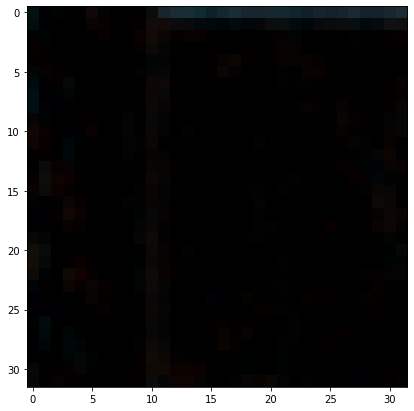

In [16]:
distance = 2
plot.plot_difference_img(oracle_data, distance)

### Preprocess data

In [3]:
n = 4
# change seq. length, recode actions, split dataset
dataset = preprocess.split_n_steps_between(oracle_reversed_random_data_small, n=n)
dataet, counter, translation_dict = preprocess.recode_actions(dataset, n)
train_data, test_data = preprocess.split_data(dataset, 0.8)

# preprocess trainingset
oracle_train_data = preprocess.ObtainDualDataset(
    train_data, "observationsA", "observationsB", "actions"
)
oracle_test_data = preprocess.ObtainDualDataset(
    test_data, "observationsA", "observationsB", "actions"
)

# build dataloader (tensor format)
batch_size = 128
dataset_loader_train_data = DataLoader(
    oracle_train_data, batch_size=batch_size, shuffle=True
)
dataset_loader_test_data = DataLoader(
    oracle_test_data, batch_size=batch_size, shuffle=True
)

### Inspect overlap of train and val. set in terms of classes

In [5]:
n_overlap = tools.determine_overlap_train_test_data(train_data, test_data)
print("Elements where class is in both train and test data:", n_overlap)

total train data: 2397
total test data: 599
Elements where class is in both train and test data: 2344


### Two images within one batch (n-steps inbetween)

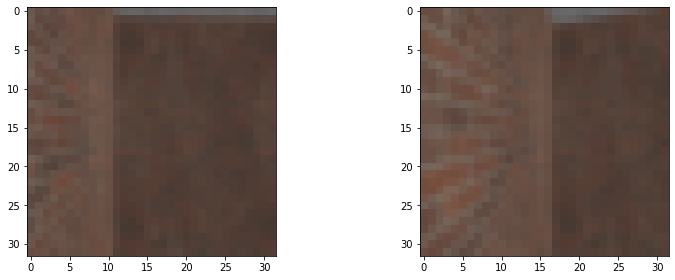

In [6]:
plot.plot_dataset_imgs(dataset)

### Initialize the model

In [7]:
forward = nets.Forward(counter)  # FC-Feed-forward network
summary(forward, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                  [-1, 256]          21,760
Total params: 82,916
Trainable params: 82,916
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.32
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


### Train model

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    forward.parameters(), lr=0.001
)  # , momentum=0.9) # for small one 0.01 works well

episodes = 10
forward, train_loss, test_loss, train_acc, test_acc = train.train_DiffImg(
    dataset_loader_train_data,
    dataset_loader_test_data,
    forward,
    criterion,
    optimizer,
    episodes,
)

Progress:   0%|          | 0/10 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 4.099, Train Acc: 4.13 %,  Test Loss: 4.093, Test Acc: 5.676 %,
Finished Training


### Plot loss and accuracy curves for training and test set

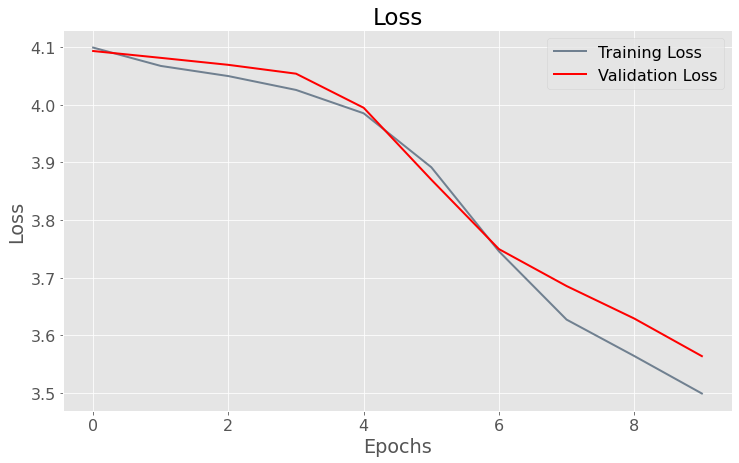

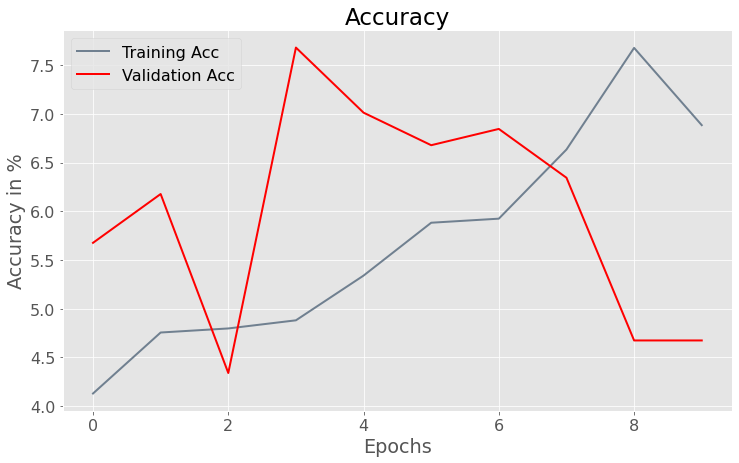

In [10]:
plot.plot_losses(train_loss, test_loss)
plot.plot_acc(train_acc, test_acc, smooth=False)